# RoBERTa: ARobustly Optimized BERT Pretraining Approach (2019)

출처: [https://arxiv.org/abs/1907.11692](https://arxiv.org/abs/1907.11692)

# Abstract
언어 모델 pretraining은 상당한 성능 향상을 가져왔지만, 다양한 approach에 대해 비교하는 것은 여전히 어렵습니다. training은 계산 비용이 많이 들고, 다양한 크기의 개인 데이터 세트에서 수행되는 경우가 많으며, hyperparameter 선택은 최종 결과에 상당한 영향을 미치기 때문입니다. 여기서는 많은 key hyperparameter와 훈련 데이터 크기의 영향을 측정하는 BERT pretraining의 replication study를 제시합니다. 여기서는 BERT가 덜 훈련되었으며, 그 이후에 발표된 모든 모델의 성능과 일치하거나 뛰어넘을 수 있음을 발견했습니다. 이 논문의 모델은 GLUE, RACE 및 SQuAD에서 SOTA를 달성합니다. 이러한 결과는 이전에 간과된 design 선택의 중요성을 강조하고 최근에 보고된 improvement의 source에 대한 질문을 제기합니다.

# 1 Introduction
ELMo, GPT, BERT, XLM 및 XLNet과 같은 self training 방법은 상당한 성능 향상을 가져왔지만, methods의 어떤 측면이 가장 크게 기여했는지 결정하는 것에 대해 어려움을 겪고 있습니다.

여기서는 BERT의 수정판인 RoBERTa를 제안합니다. 수정 사항은 다음과 같이 간단합니다. (1) 더 많은 데이터에 대해 더 큰 batch로 모델을 더 오래 training (2) next prediction objective 제거 (3) 더 긴 sequence로 training (4) training 데이터에 적용된 masking pattern을 동적으로 변경하는 단계를 포함합니다. 또한, 훈련 세트 크기 효과를 더 잘 제어하기 위해 다른 개인이 사용하는 데이터 세트와 비슷한 크기의 대규모 새 데이터 세트(CC-NEWS)를 수집합니다.

훈련 데이터를 제어할 때, 개선된 training procedure는 GLUE, SQuAD 모두에 게시된 BERT 결과를 개선합니다.

요약하면, 이 논문의 contribution은 다음과 같습니다. (1) 중요한 BERT design 선택 및 training 전략을 제시하고 더 나은 downstream task 성능으로 이어지는 대안을 소개합니다. (2) 새로운 데이터 세트인 CC-NEWS를 사용하고 pretraining에 더 많은 데이터를 사용하면 downstream task의 성능이 더욱 향상됨을 확인합니다. (3) 여기서의 training의 개선 사항은 올바른 design 선택 하에서의 masked language model pretraining이 최근에 발표된 다른 모든 방법과 비교했을 때, 경쟁력이 있음을 보여줍니다.

# 2 Background
이 섹션에서는 BERT pretraining approach에 대한 간략한 개요와 다음 섹션에서 실험적으로 검토할 training 선택 사항 중 일부를 제공합니다.

## 2.1 Setup
BERT는 $x_{1}, \ldots, x_{N}$와 $y_{1}, \ldots, y_{M}$의 두 segments(token sequence)의 연결을 입력으로 사용합니다. segment는 일반적으로 하나 이상의 문장으로 구성됩니다. 두 segments는 special tokens를  사용하여 하나의 input sequence로 BERT에서는 표현됩니다: $[C L S], x_{1}, \ldots, x_{N},[S E P], y_{1}, \ldots, y_{M},[E O S]$. 

$M$과 $N$은 $M\, +\, N\, <\, T$가 되도록 제한됩니다. 여기서 T는 training 중 최대 sequence 길이를 제어하는 parameter입니다.

모델은 먼저 레이블이 지정되지 않은 large text corpus에서 pretraining된 후, end-task labels data를 사용하여 fine-tuning합니다.

## 2.2 Architecture
BERT는 ubiquitous transformer architecture를 사용하므로 자세히 살펴보지 않습니다. 여기서는 $L$ layers가 있는 transformer architecture를 사용합니다. 각 block은 $A$ self-attention head와 hidden dimension $H$를 사용합니다.

## 2.3 Training Objectives

**Masked Language Model (MLM)**

- input sequence에서 token의 random sample이 선택되고 special token $[MASK]$로 대체됩니다. MLM objective는 masked tokens를 예측할 때, cross-entropy loss입니다. BERT는 input tokens의 15%를 선택하고, 선택된 token 중 80%는 $[MASK]$로 바꾸고, 10%는 변경하지 않고, 10%는 random한 vocabulary token으로 바꿉니다.

- 원래 구현에서는 random masking과 교체 작업이 처음에 한 번 수행되고 training 기간 동안 저장되지만, 실제로는 데이터가 복제되므로 mask가 모든 training 문장에 대해 항상 동일하지는 않습니다. (Section 4.1에서 확인)

**Next Sentence Prediction (NSP)**

- NSP는 original text에서 두 segments가 서로 이어지는지 여부를 예측하기 위한 binary classification loss입니다. positive 예는 text corpus에서 연속적인 문장을 취함으로써 생성됩니다. negative 예는 다른 문서의 segment를 pairing하여 생성됩니다. positive 및 negative 예는 동일한 확률로 샘플링됩니다.

- NSP objective는 pairs of sentences 간의 관계에 대한 추론이 필요한 Natual Language Inference와 같은 downstream task의 성능을 향상시키도록 설계되었습니다.

## 2.4 Optimization
BERT는 $β_1\, =\, 0.9$, $β_2\, =\, 0.999$, $\epsilon\, =\, 1e-6$와 $L_2$ weight decay 0.01을 parameters로 사용하여 Adam으로 최적화됩니다. learning rate은 처음 10,000단계에서 1e-4의 peak value로 warm-up한 다음 조금씩 감소합니다. BERT는 모든 layer와 attention weights에서 0.1의 dropout과 GELU activation function으로 training합니다. 모델은 mini batch $B\, =\, 256$, sequences of maximum length $T\, =\, 512$ tokens를 포함하는 $S\, =\, 1,000,000$ updatas로 pre-training합니다.

# 3 Experimental Setup

이 섹션에서는 BERT의 replication study를 위해 experimental setup에 대해 설명합니다.

## 3.1 Implementation
peak learning rate과 warmup step의 수를 제외하고, Section 2에 제공된 원래의 BERT optimization hyperparameters를 따릅니다. 여기서는 또한 training이 Adam의 epsilon에 매우 민감하다는 것을 발견했으며, 어떤 경우에는 tuning 후, 더 나은 성능과 안정성을 얻었습니다. 유사하게, 큰 batch size로 training할 때 안정성을 개선하기 위해 $β_2 = 0.98$을 설정해야 한다는 것을 발견했습니다.

또한, 짧은 sequence를 무작위로 주입하지 않으며 update의 처음 90%에 대해 reduced sequence length로 training하지 않습니다. 여기서는 full-length sequence로만 training합니다.

# 4 Training Procedure Analysis

## 4.1 Static vs. Dynamic Masking

Section 2에서 논의한 바와 같이 BERT는 token을 무작위로 masking하고 예측합니다. 원래 BERT 구현은 데이터 preprocessing 중에 masking을 한 번 수행하여 single static mask를 생성했습니다. 모든 epoch의 각 training instance에 대해 동일한 mask를 사용하는 것을 피하기 위해 training 데이터를 10번 복제하여 각 sequence가 40개의 training epoch에 걸쳐 10가지 다른 방식으로 masking되었습니다. 따라서, 각 training sequence는 training 중에 동일한 mask로 4번 표시되었습니다.

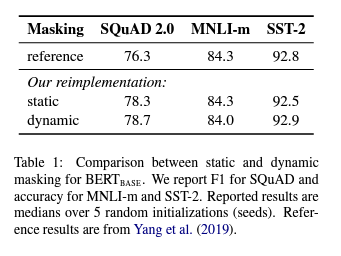

static masking을 사용한 reimplementation은 원래 BERT 모델과 유사하게 수행되며, dynamic masking은 static masking과 비슷하거나 약간 더 성능이 우수합니다. 이러한 결과와 dynamic masking의 추가 효율성 이점을 감안할 때, 나머지 experiments에서 dynamic masking을 사용합니다.

## 4.2 Model Input Format and Next Sentence Prediction

- $SEGMENT-PAIR+NSP$: NSP loss와 함께 BERT에서 사용된 원래 input format을 따릅니다. 각 input에는 여러 개의 natural sentence을 포함할 수 있는 한 쌍의 segment가 있지만 총 합친 길이는 512 tokens 미만이어야 합니다.

- $SENTENCE-PAIR+NSP$: 각 input에는 한 document의 연속된 부분이나 개별 document에서 sampling된 한 쌍의 문장이 포함됩니다. 이러한 input은 512 tokens보다 훨씬 짧기 때문에 총 token 수가 $SEGMENT-PAIR+NS$P와 유사하게 유지되도록 batch size를 늘립니다. 여기서는 NSP loss를 유지합니다.

- $FULL-SENTENCES$: 각 input은 전체 길이가 최대 512 tokens가 되도록 하나 이상의 document에서 연속적으로 sampling된 문장으로 되어 있습니다. input은 document boundary를 넘을 수 있습니다. 한 document의 끝에 도달하면 다음 document에서 문장 sampling을 시작하고 document 사이에 별도의 separator token을 추가합니다. 여기서는 NSP loss를 제거합니다.

- $DOC-SENTENCES$: input은 document boundary를 넘을 수 없다는 점을 제외하고는 $FULL-SENTENCES$와 유사하게 구성됩니다. 문서 끝 부분에서 samping된 input은 512 tokens보다 짧을 수 있으므로 이러한 경우, batch size를 늘려 $FULL-SENTENCES$와 유사한 총 token 수를 만듭니다. 여기서는 NSP loss를 제거합니다.

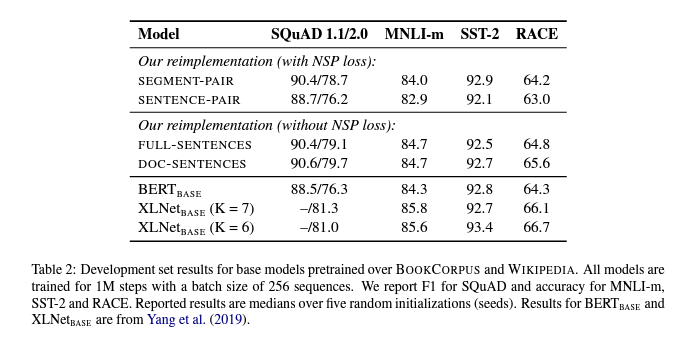


**Results**

- 개별 문장을 사용하면 downstream task의 성능이 저하된다는 사실을 발견했습니다. 이는 모델이 long-range dependency를 학습할 수 없기 때문입니다.

- NSP loss를 제거하면 downstream task 성능이 일치하거나 약간 향상된다는 것을 발견했습니다.

- 하나의 document(DOC-SENTENCES)에서 오는 sequence를 제한하는 것이 여러 document(FULL-SENTENCES)에서 시퀀스를 packing하는 것보다 약간 더 나은 성능을 보입니다.

## 4.3 Training with large batches
learning rate이 적절하게 증가할 때, batch size가 클수록 optimization speed와 end-task 성능을 향상시킵니다.

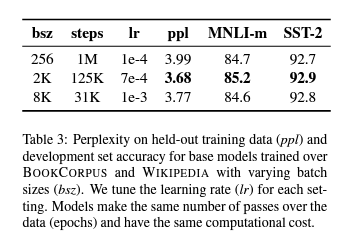

## 4.4 Text Encoding
Radford et al. (2019)는 base subword units로 unicode character 대신 bytes를 사용하는 BPE 구현을 소개합니다. bytes를 사용하면 unknown tokens을 도입하지 않고도 모든 input text를 인코딩할 수 있는 적당한 크기(50K units)의 subword vocabulary를 학습할 수 있습니다.

# 5 RoBERTa
RoBERTa는 dynamic masking(Section 4.1), NSP loss가 없는 $FULL_SENTENCES$(Section 4.2), large mini-batches(Section 4.3) 그리고 더 큰 byte-level BPE(Section 4.4)로 training됩니다.

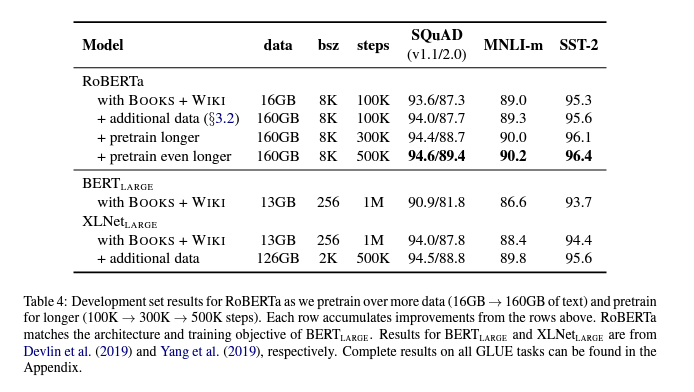

## 5.1 GLUE Results

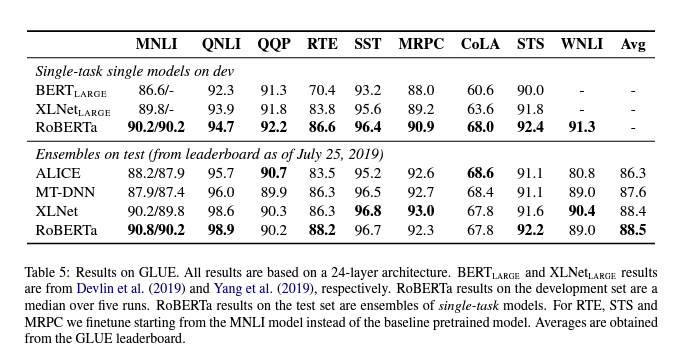

## 5.2 SQuAD Results

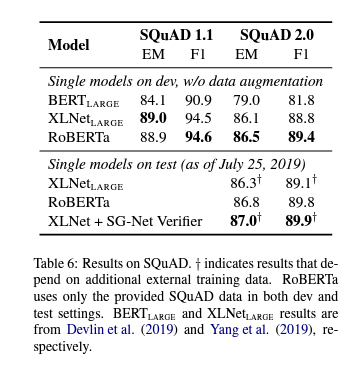

## 5.3 RACE Results

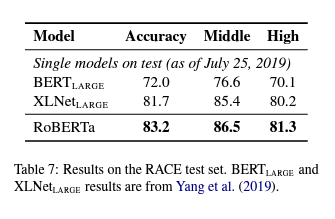

# 7 Conclusion
이 논문에서는 BERT 모델을 pretraining할 때 여러 design decision을 평가합니다. 여기서는는 더 많은 데이터에 대해 더 큰 batch를 사용하여 모델을 더 오래 training함으로써 성능이 크게 향상될 수 있음을 발견했습니다 (next sentence prediction objective를 제거하는 단계; 더 긴 sequence로 training; 훈련 데이터에 적용된 masking pattern을 dynamic하게 변경하는 단계를 포함). RoBERTa라고 하는 개선된 pretraining procedure는 GLUE에 대한 multi-task finetuning 또는 SQuAD에 대한 추가 데이터 없이 GLUE, RACE 및 SQuAD에서 SOTA를 달성합니다. 이러한 결과는 이전에 간과된 이러한 design decision의 중요성을 보여주고 BERT의 pretraining objective가 최근 제안된 대안과 비교했을 때, 경쟁력이 있음을 시사합니다.

--------------

# Appendix

## Hyperparameters

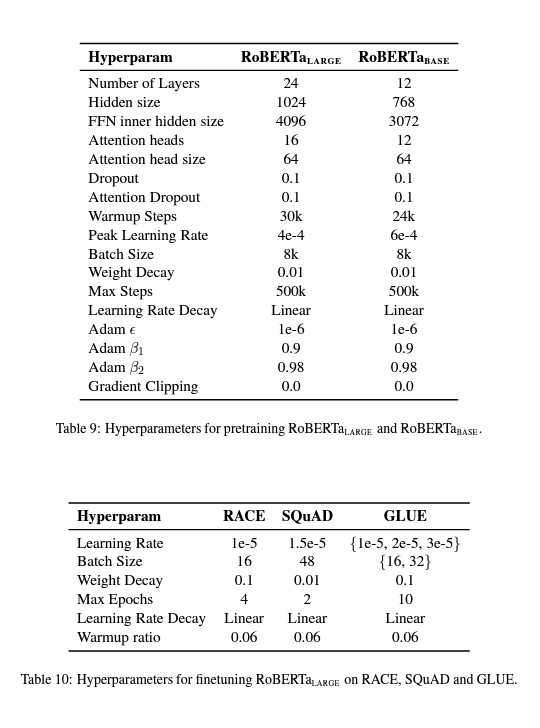